In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("final_list2.csv")

In [3]:
def is_float(string):
    try:
        return float(string)  # True if string is a number contains a dot
    except ValueError:  # String is not a number
        return False

## Feature Engineering

In [4]:
def convToBinary(s):
    if s is None or s == "" or pd.isnull(s):
        return 0
    if s.upper() == "YES":
        return 1
    return 0

df['Jack'] = df['3.5mm jack'].apply(convToBinary)
df['GPS'] = df['GPS Support'].apply(convToBinary)
df['NFCB'] = df['NFC'].apply(convToBinary)

In [5]:
def getCardSlot(s):
    if s is None or s == "" or pd.isnull(s):
        return np.nan
    l = s.upper().split()
    if "GB" in l:
        ind = l.index("GB") - 1
        if is_float(l[ind]):
            return float(l[ind])
        else:
            return 0
    
df['CardSlotVal'] = df['Card slot'].apply(getCardSlot)
df['IntStorage'] = df['Internal Storage'].apply(getCardSlot)

In [6]:
def getClockSpeed(s):
    if s is None or s == "" or pd.isnull(s):
        return np.nan
    l = s.upper().split()
    if "GHZ" in l:
        ind = l.index("GHZ") - 1
        if is_float(l[ind]):
            return float(l[ind])
        else:
            return 0
    
df['ClockSpeed'] = df['Clock Speed'].apply(getClockSpeed)

In [7]:
def getSensorCount(s):
    if s is None or s == "" or pd.isnull(s):
        return np.nan
    if is_float(s):
        return float(s)
    return len(s.split(","))

df['SensorCount'] = df['Sensors'].apply(getSensorCount)

In [8]:
def getPrimCam(s):
    if s is None or s == "" or pd.isnull(s):
        return np.nan
    l = s.upper().split()
    if "MP" in l:
        ind = l.index("MP") - 1
        if is_float(l[ind]):
            return float(l[ind])
        else:
            return 0
    
df['PrimCam'] = df['Primary Camera'].apply(getPrimCam)
df['SecCam'] = df['Secondary Camera'].apply(getPrimCam)

In [9]:
def myfunc(s):
    if s is None or s == "" or s is np.nan or s == "-" or s == "~":
        return 0
    return s.upper().split()[0]

df['Wt'] = df['Weight'].apply(myfunc)
df['Res'] = df['Resolution'].apply(myfunc)

## Predicting prices using ridge regression

In [119]:
columns = [
'Battery',
'Jack',
'CardSlotVal',
'ClockSpeed',
'GPS',
'IntStorage',
'NFCB',
'PrimCam',
'Res',
'SecCam',
'Wt',
'SensorCount',
'Price'
]

temp = df[columns]
temp = temp.dropna(axis=0, how='any')


In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

scaler = MinMaxScaler() 

# split data into training and test
temp = temp.sample(frac=1)
n = len(temp)
temp_1 = temp.iloc[:int(5 * n / 10), :]
temp_2 = temp.iloc[int(5 * n / 10) + 1:, :]

tempcol = columns[:]
tempcol.remove('Price')


# normalize the data
y_1 = temp_1['Price']
temp_1 = temp_1[columns]
scaled_values = scaler.fit_transform(temp_1) 
temp_1.loc[:,:] = scaled_values

y_2 = temp_2['Price']
temp_2 = temp_2[columns]
scaled_values = scaler.fit_transform(temp_2) 
temp_2.loc[:,:] = scaled_values



# linear regression
model = Ridge(alpha=1.0)#model = LinearRegression(fit_intercept=False)

model.fit(temp_1, y_1)
l = zip(tempcol, model.coef_)
l.sort(key = lambda x:abs(x[1]), reverse=True)
l

[('SecCam', 103.61128403695972),
 ('SensorCount', 101.33112919772857),
 ('CardSlotVal', 75.329380260503541),
 ('IntStorage', 72.225378862027625),
 ('Wt', 69.910655518503759),
 ('PrimCam', -67.434651646837025),
 ('Res', 65.092128408551588),
 ('Battery', -51.226883540380328),
 ('ClockSpeed', -41.39732556021459),
 ('NFCB', 14.801682658847332),
 ('Jack', 0.0),
 ('GPS', 0.0)]

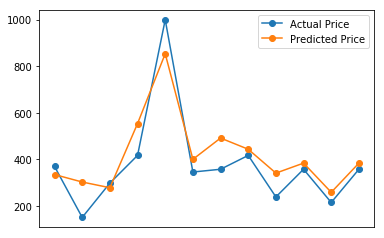

In [121]:
import matplotlib.pyplot as plt

ypred = model.predict(temp_2)
n = len(temp_2)
plt.plot(range(1, n + 1), y_2, label = "Actual Price", marker='o')
plt.plot(range(1, n + 1), ypred, label = "Predicted Price", marker='o')
plt.xticks([])

plt.legend()

## Correlation

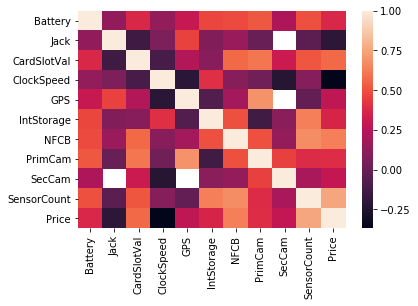

In [26]:
# import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline

df2 = df[columns]

# calculate the correlation matrix
corr = df2.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


In [19]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


,Battery,Jack,CardSlotVal,ClockSpeed,GPS,IntStorage,NFCB,PrimCam,SecCam,SensorCount,Price
Battery,1,0.13,0.38,0.14,0.3,0.47,0.49,0.52,0.22,0.5,0.37
Jack,0.13,1,-0.14,0.067,0.47,0.076,0.16,-0.0031,nan,-0.039,-0.21
CardSlotVal,0.38,-0.14,1,-0.11,0.23,0.099,0.57,0.6,0.31,0.52,0.57
ClockSpeed,0.14,0.067,-0.11,1,-0.22,0.4,0.097,0.022,-0.23,0.092,-0.37
GPS,0.3,0.47,0.23,-0.22,1,-0.075,0.19,0.69,nan,-0.021,0.28
IntStorage,0.47,0.076,0.099,0.4,-0.075,1,0.5,-0.14,0.11,0.63,0.36
NFCB,0.49,0.16,0.57,0.097,0.19,0.5,1,0.5,0.14,0.68,0.63
PrimCam,0.52,-0.0031,0.6,0.022,0.69,-0.14,0.5,1,0.46,0.39,0.39
SecCam,0.22,nan,0.31,-0.23,nan,0.11,0.14,0.46,1,0.2,0.29
SensorCount,0.5,-0.039,0.52,0.092,-0.021,0.63,0.68,0.39,0.2,1,0.76
